In [187]:
# 필요 패키지들을 호출
from collections import defaultdict
from IPython.display import clear_output
import numpy as np
import random
import gym

import pandas as pd
import matplotlib.pyplot as plt

In [146]:
a = [1,2,3,4,5]
print(np.random.choice(a))
print(random.choice(a))

2
3


In [148]:
# Cliff walking 환경 정의
env = gym.make('CliffWalking-v0')

In [149]:
# Cliff walking에 대한 설명문
env.__doc__

'\n    This is a simple implementation of the Gridworld Cliff\n    reinforcement learning task.\n\n    Adapted from Example 6.6 (page 145) from Reinforcement Learning: An Introduction\n    by Sutton and Barto:\n    http://people.inf.elte.hu/lorincz/Files/RL_2006/SuttonBook.pdf\n    \n    With inspiration from:\n    https://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/cliff_walking.py\n\n    The board is a 4x12 matrix, with (using Numpy matrix indexing):\n        [3, 0] as the start at bottom-left\n        [3, 11] as the goal at bottom-right\n        [3, 1..10] as the cliff at bottom-center\n\n    Each time step incurs -1 reward, and stepping into the cliff incurs -100 reward \n    and a reset to the start. An episode terminates when the agent reaches the goal.\n    '

In [150]:
# 현재 state의 Cliff walking 환경을 시각화합니다.
env.render()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



In [151]:
# gym 환경의 기본 기능을 익혀봅시다
# env.reset() : 환경 개시
# env.step(action): 환경 행동부여
# env.render(): 환경 시각화 -> 이미지 혹은 텍스트(Gridworld)
state = env.reset()
print(state)

36


In [66]:
env.action_space.n

4

In [67]:
# 에이전트가 행동을 하는 것을 모사
# 출력값: 다음상태, 보상, 종료여부, 정보 
# 정보는 환경과 관련된 부수적인 요소들을 딕셔너리 형태로 포함 -> 생략해도 무방
next_state,reward,done,infs = env.step(env.action_space.sample())

In [68]:
print(next_state, reward, done)

36 -1 False


In [69]:
env.render()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



In [167]:
# Q-learning 에이전트 작성
class Qlearning:
    def __init__(self,possible_actions,alpha=0.25,epsilon=0.2,gamma=0.99):
        '''
        초기 입력인자
            possible_actions: State에서 에이전트가 취할수 있는 행동, (defaultdict s)
            alpha: 학습률
            epsilon: Exploration 확률 <- 학습초기: 높은확률, 학습후기: 낮은확률
            gamma: 할인율
        Class의 속성
            Q-함수 정의 -> self.def_qvalue
            Q-함수 출력 -> self.get_qvalue
            Q-함수 업데이트 -> self.update_qvalue
            행동 추출 
                -> self.epsilon_action
                -> self.argmax_action
        '''
        self.possible_actions=possible_actions
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.q_value = defaultdict(lambda: defaultdict(lambda: 0))
        
    def def_qvalue(self,state,action,q_value):
        '''
        Q-함수값 정의, Q(s,a) <- q_value
            입력: state, action, q_value
            출력: X
        '''
        self.q_value[state][action] = q_value
    
    def get_qvalue(self,state,action):
        '''
        Q-함수값 출력
            입력: state, action
            출력: Q(s,a)
        '''
        return self.q_value[state][action]
    
    def max_Q(self,state):
        '''
        max_{a}Q(s',a) 구하기
            입력: state
            출력: max_{a}Q(s,a)
        '''
        possible_actions = self.possible_actions(state)
        Qs = []
        for possible_action in possible_actions:
            Qs.append(self.get_qvalue(state,possible_action))
        Qs = max(Qs)
        return Qs
    
    def update(self,state,action,reward,next_state):
        '''
        Q-learning 업데이트식, Q(s,a) <- Q(s,a) + alpha*(reward+gamma*max(Q(s',a'))-Q(s,a))
            입력: state, action, reward, next_state
            출력: X
        '''
        next_q = self.max_Q(next_state)
        # 업데이트식
        rhs = (1-self.alpha)*self.get_qvalue(state,action)+self.alpha*(reward+self.gamma*next_q) 
        self.def_qvalue(state,action,rhs)
    
    def max_action(self,state):
        '''
        Q-함수값에 전적으로 의존한 최적의 action -> argmax_{a}Q(s,a)
            입력: state
            출력: action
        '''
        Qmax = self.max_Q(state)
        possible_actions = self.possible_actions(state)
        action = np.random.choice(possible_actions)
        for possible_action in possible_actions:
            Qvalue = self.get_qvalue(state,possible_action)
            if Qvalue >= Qmax:
                Qmax = Qvalue
                action = possible_action
        return action
    
    def epsilon_action(self,state):
        '''
        Epsilon-greedy 방식에 근거한 행동추출
        -> 임의로 정의한 확률 p와 epsilon을 비교, 작은경우: Exploration, 큰 경우: Exploitation
            입력: state
            출력: 현재 state에 적절한 action
        '''
        possible_actions = self.possible_actions(state)
        p = np.random.uniform(0,1)
        if p <= self.epsilon: # Exploration
            best_action = np.random.choice(possible_actions)
        else: # Exploitation
            best_action = self.max_action(state)
        return best_action

In [168]:
# SARSA 에이전트 작성
class SARSA:
    def __init__(self,possible_actions,alpha=0.25,epsilon=0.2,gamma=0.99):
        '''
        초기 입력인자
            possible_actions: 에이전트가 취할수 있는 행동 <- env.action_space.n을 통해서 입력
            alpha: 학습률
            epsilon: Exploration 확률 <- 학습초기: 높은확률, 학습후기: 낮은확률
            gamma: 할인율
        Class의 속성
            Q-함수 정의 -> self.def_qvalue
            Q-함수 출력 -> self.get_qvalue
            Q-함수 업데이트 -> self.update_qvalue
            행동 추출 -> self.get_action
        '''
        self.possible_actions=possible_actions
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.q_value = defaultdict(lambda: defaultdict(lambda: 0))
        
    def def_qvalue(self,state,action,q_value):
        '''
        Q-함수값 정의, Q(s,a) <- q_value
            입력: state, action, q_value
            출력: X
        '''
        self.q_value[state][action] = q_value
    
    def get_qvalue(self,state,action):
        '''
        Q-함수값 출력
            입력: state, action
            출력: Q(s,a)
        '''
        return self.q_value[state][action]
    
    def max_Q(self,state):
        '''
        max_{a}Q(s',a) 구하기
            입력: state
            출력: max_{a}Q(s,a)
        '''
        possible_actions = self.possible_actions(state)
        Qs = []
        for possible_action in possible_actions:
            Qs.append(self.get_qvalue(state,possible_action))
        Qs = max(Qs)
        return Qs
    
    def update(self,state,action,reward,next_state):
        '''
        SARSA 업데이트식, Q(s,a) <- Q(s,a) + alpha*(reward+gamma*Q(s',a')-Q(s,a))
        (a' <- epsilon-greedy 정책)
            입력: state, action, reward, next_state
            출력: X
        '''
        next_action = self.epsilon_action(next_state)
        next_q = self.get_qvalue(next_state,next_action)
        rhs = (1-self.alpha)*self.get_qvalue(state,action)+self.alpha*(reward+self.gamma*next_q) # 업데이트식
        self.def_qvalue(state,action,rhs)
    
    def max_action(self,state):
        '''
        Q-함수값에 전적으로 의존한 최적의 action -> argmax_{a}Q(s,a)
            입력: state
            출력: action
        '''
        Qmax = self.max_Q(state)
        possible_actions = self.possible_actions(state)
        action = np.random.choice(possible_actions)
        for possible_action in possible_actions:
            Qvalue = self.get_qvalue(state,possible_action)
            if Qvalue >= Qmax:
                Qmax = Qvalue
                action = possible_action
        return action
    
    def epsilon_action(self,state):
        '''
        Epsilon-greedy 방식에 근거한 행동추출
        -> 임의로 정의한 확률 p가 epsilon와 비교, 작은경우: Exploration, 큰 경우: Exploitation
            입력: state
            출력: 현재 state에 적절한 action
        '''
        possible_actions = self.possible_actions(state)
        p = np.random.uniform(0,1)
        if p <= self.epsilon: # Exploration
            best_action = np.random.choice(possible_actions)
        else: # Exploitation
            best_action = self.max_action(state)
        return best_action

In [173]:
def play_and_train(env, agent, t_max=10**4):
    '''
    에이전트 학습 코드(gym style)
    입력인자
        env: 환경 -> Cliff walking
        agent: 에이전트 -> Q-agent, SARSA_agent
        t_max: 최대 시점 -> 강제 에피소드 종료시점 설정
    출력인자
        total_reward: 최종보상(할인 X)
    '''
    total_reward = 0.0
    s = env.reset()

    for t in range(t_max):
        a = agent.epsilon_action(s)
        
        next_s, r, done, _ = env.step(a)
        agent.update(s, a, r, next_s)

        s = next_s
        total_reward += r
        if done:
            break

    return total_reward

In [195]:
# 각 행동에는 4개의 행동이 가능 - 상,하,좌,우
n_actions = env.action_space.n
Q_agent = Qlearning(lambda s: range(n_actions))
SARSA_agent = SARSA(lambda s: range(n_actions))

2900번째 에피소드 결과
SARSA 보상평균(100 에피소드) = -28.77
Q-Learning 보상평균(100 에피소드) = -111.66


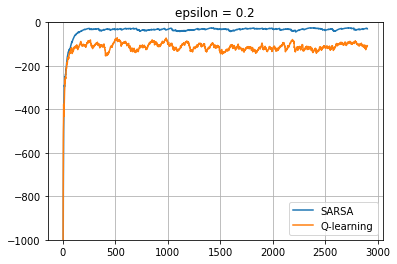

In [196]:
def moving_average(x, span=100):
    return pd.DataFrame({'x': np.asarray(x)}).x.ewm(span=span).mean().values

rewards_sarsa, rewards_ql = [], []
for i in range(2000):
    rewards_sarsa.append(play_and_train(env, SARSA_agent))
    rewards_ql.append(play_and_train(env, Q_agent))

    if i % 100 == 0:
        clear_output(True)
        print(f'{i}번째 에피소드 결과')
        print(f'SARSA 보상평균(100번 에피소드) = {np.mean(rewards_sarsa[-100:])}')
        print(f'Q-Learning 보상평균(100번 에피소드) = {np.mean(rewards_ql[-100:])}')
        mean_sarsa.append(np.mean(rewards_sarsa[-100:]))
        mean_q.append(np.mean(rewards_ql[-100:]))
        
        plt.title("epsilon = %s" % Q_agent.epsilon)
        plt.plot(moving_average(rewards_sarsa),label='SARSA')
        plt.plot(moving_average(rewards_ql),label='Q-learning')
        
        plt.grid()
        plt.legend()
        plt.ylim(-1000, 0)
        plt.show()